In [29]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [40]:
d = np.load(test_path)
tokens_np = d["tokens"].astype(np.float32)  # (N, K, 4)
masks_np  = d["masks"].astype(np.bool_)     # (N, K)
truth_np  = d["truth"].astype(np.float32)   # (N,)

N, K, F = tokens_np.shape
print("tokens:", tokens_np.shape, tokens_np.dtype)
print("masks :", masks_np.shape, masks_np.dtype)
print("truth :", truth_np.shape, truth_np.dtype)
print("E_true range:", float(truth_np.min()), "to", float(truth_np.max()))
print("Avg valid tokens:", float(masks_np.sum(axis=1).mean()))

tokens: (5000, 128, 4) float32
masks : (5000, 128) bool
truth : (5000,) float32
E_true range: 5.026456356048584 to 199.86712646484375
Avg valid tokens: 128.0


In [41]:
from torch.utils.data import Dataset, DataLoader

class EcalTokenDataset(Dataset):
    def __init__(self, tokens, masks, truth):
        self.tokens = tokens
        self.masks  = masks
        self.truth  = truth

    def __len__(self):
        return len(self.truth)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.tokens[idx])  
        m = torch.from_numpy(self.masks[idx])      
        y = torch.tensor(self.truth[idx]).float()  
        return x, m, y

test_ds = EcalTokenDataset(tokens_np, masks_np, truth_np)

test_loader = DataLoader(
    test_ds,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    pin_memory=(device == "cuda")
)

print("test events:", len(test_ds))

test events: 5000


In [44]:
class SumCalibBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))

    def forward(self, tokens, mask):
        e = tokens[..., 3] * mask.to(tokens.dtype)
        s = e.sum(dim=1)
        return self.a * s + self.b


class TokenEmbed(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.coord_mlp = nn.Sequential(
            nn.Linear(2, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model),
        )
        self.energy_mlp = nn.Sequential(
            nn.Linear(2, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model),
        )
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, tokens):
        xy = tokens[..., 0:2]   
        le = tokens[..., 2:4]   
        x = self.coord_mlp(xy) + self.energy_mlp(le)
        return self.drop(self.norm(x))


class TransformerRegressor(nn.Module):
    def __init__(self, d_model=96, n_heads=4, n_layers=3, dropout=0.1, mlp_ratio=4, pooling="cls"):
        super().__init__()
        self.pooling = pooling
        self.embed = TokenEmbed(d_model=d_model, dropout=dropout)

        if pooling == "cls":
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.normal_(self.cls, std=0.02)
        else:
            self.cls = None

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=int(d_model * mlp_ratio),
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1),
        )

    def forward(self, tokens, mask):
        x = self.embed(tokens)     
        pad_mask = ~mask        

        if self.pooling == "cls":
            B = x.size(0)
            cls = self.cls.expand(B, -1, -1)       
            x = torch.cat([cls, x], dim=1)     
            cls_pad = torch.zeros((B, 1), device=pad_mask.device, dtype=pad_mask.dtype)
            pad_mask = torch.cat([cls_pad, pad_mask], dim=1)

        x = self.encoder(x, src_key_padding_mask=pad_mask)

        if self.pooling == "cls":
            pooled = x[:, 0]
        else:
            m = mask.to(x.dtype).unsqueeze(-1)
            pooled = (x * m).sum(dim=1) / m.sum(dim=1).clamp_min(1.0)

        return self.head(pooled).squeeze(-1)

In [35]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    preds, truth = [], []
    for tokens, mask, y in loader:
        tokens = tokens.to(device, non_blocking=True)
        mask   = mask.to(device, non_blocking=True)
        p = model(tokens, mask).detach().cpu().numpy()
        preds.append(p)
        truth.append(y.numpy())
    return np.concatenate(preds), np.concatenate(truth)

E_pred_b, E_true = predict(baseline, test_loader)
E_pred_t, _      = predict(transformer, test_loader)

print("Shapes:", E_pred_b.shape, E_pred_t.shape, E_true.shape)
print("Corr baseline    :", np.corrcoef(E_true, E_pred_b)[0,1])
print("Corr transformer :", np.corrcoef(E_true, E_pred_t)[0,1])

Shapes: (5000,) (5000,) (5000,)
Corr baseline    : 0.9970522880713873
Corr transformer : 0.9964250619797975


In [45]:
def response(E_pred, E_true):
    return E_pred / np.clip(E_true, 1e-8, None)

def binned_stats(E_true, values, bins):
    idx = np.digitize(E_true, bins) - 1
    centers, means, stds, counts = [], [], [], []
    for b in range(len(bins)-1):
        sel = idx == b
        if np.any(sel):
            centers.append(0.5*(bins[b] + bins[b+1]))
            means.append(values[sel].mean())
            stds.append(values[sel].std())
            counts.append(int(sel.sum()))
    return np.array(centers), np.array(means), np.array(stds), np.array(counts)

bins = np.array([5, 10, 20, 40, 80, 120, 160, 200], dtype=np.float32)

r_b = response(E_pred_b, E_true)
r_t = response(E_pred_t, E_true)

c_b, mean_b, std_b, n_b = binned_stats(E_true, r_b, bins)
c_t, mean_t, std_t, n_t = binned_stats(E_true, r_t, bins)

print("Bin centers:", c_b)
print("Counts:", n_b)

Bin centers: [  7.5  15.   30.   60.  100.  140.  180. ]
Counts: [ 148  276  524 1020 1001 1022 1009]


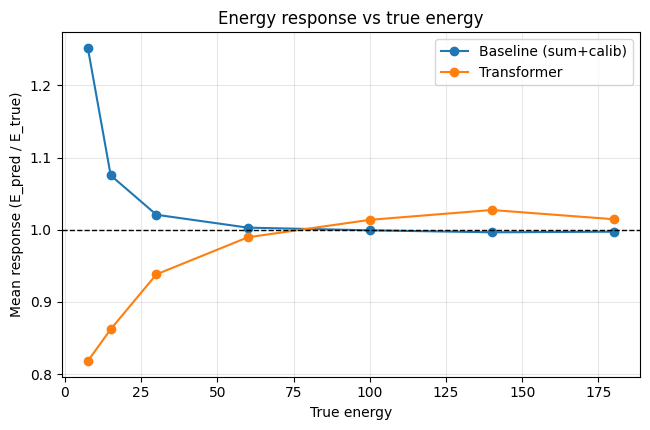

Saved: C:\Users\prachinandi\OneDrive - Microsoft\Desktop\Research Projects\Academic-Projects-ml-lab\ecal-transformer-reconstruction\results\figures\response_baseline_vs_transformer.png


In [47]:
plt.figure(figsize=(6.6, 4.4))
plt.plot(c_b, mean_b, marker="o", label="Baseline (sum+calib)")
plt.plot(c_t, mean_t, marker="o", label="Transformer")
plt.axhline(1.0, color="black", ls="--", lw=1)
plt.xlabel("True energy")
plt.ylabel("Mean response (E_pred / E_true)")
plt.title("Energy response vs true energy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

out = os.path.join(FIG_DIR, "response_baseline_vs_transformer.png")
plt.savefig(out, dpi=180)
plt.show()

print("Saved:", out)

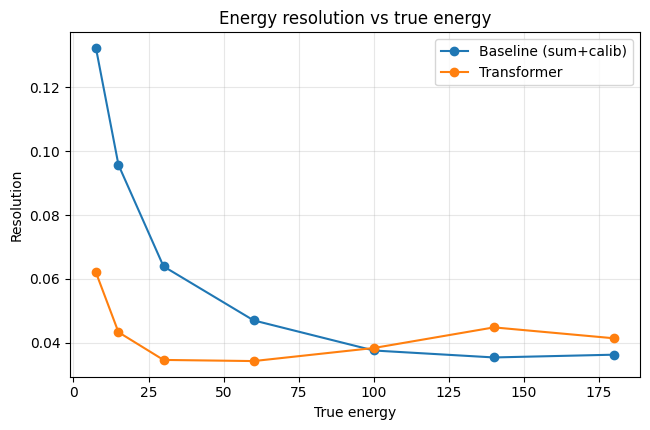

Saved: C:\Users\prachinandi\OneDrive - Microsoft\Desktop\Research Projects\Academic-Projects-ml-lab\ecal-transformer-reconstruction\results\figures\resolution_baseline_vs_transformer.png


In [48]:
plt.figure(figsize=(6.6, 4.4))
plt.plot(c_b, std_b, marker="o", label="Baseline (sum+calib)")
plt.plot(c_t, std_t, marker="o", label="Transformer")
plt.xlabel("True energy")
plt.ylabel("Resolution")
plt.title("Energy resolution vs true energy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

out = os.path.join(FIG_DIR, "resolution_baseline_vs_transformer.png")
plt.savefig(out, dpi=180)
plt.show()

print("Saved:", out)

In [49]:
metrics = {
    "bins": bins.tolist(),
    "baseline": {
        "centers": c_b.tolist(),
        "mean_response": mean_b.tolist(),
        "resolution_sigma": std_b.tolist(),
        "counts": n_b.tolist(),
    },
    "transformer": {
        "centers": c_t.tolist(),
        "mean_response": mean_t.tolist(),
        "resolution_sigma": std_t.tolist(),
        "counts": n_t.tolist(),
    }
}

json_path = os.path.join(MET_DIR, "eval_metrics_response_resolution.json")
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=2)

npz_path = os.path.join(MET_DIR, "eval_metrics_response_resolution.npz")
np.savez_compressed(
    npz_path,
    bins=bins,
    centers=c_b,
    mean_baseline=mean_b,
    res_baseline=std_b,
    mean_transformer=mean_t,
    res_transformer=std_t,
    counts=n_b
)